In [1]:
%matplotlib inline

from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [2]:
## Inputs

# Dimensionless Parameters
alpha = 5.  # k*L^2/D
beta = 1.   # f*(S0/C0)^(1/n)
n = 3.      # n

# Boundary conditions
theta_BC = [1., 0.]

# Solver parameters
seg = 100   # Number of length segments
dt = 0.025   # Time step size
tf = 1.5    # Final time

In [3]:
L_seg = 1 / seg                     # Length of segment
dist = np.linspace(0., 1., seg + 2) # Distance array
nt = int(tf / dt) + 1               # Length of time array

In [4]:
# Create new GEKKO object
m = GEKKO()

# Create time array
m.time = np.linspace(0., tf, nt)

# Left BC
theta0 = m.MV(lb = 0., ub = 1.)
theta0.value = np.ones(nt) * theta_BC[0]

# Right BC
theta1 = m.MV(lb = 0., ub = 1.)
theta1.value = np.ones(nt) * theta_BC[1]

# Initialize concentration variables
theta = [m.Var(0., lb = 0., ub = 1.) for i in range(seg)]
theta_BL = [m.Var(0., lb = 0., ub = 1.) for i in range(seg)]
# theta_ads = [m.Var(0, lb = 0, ub = 1) for i in range(seg)]

In [5]:
## Equations to be solved

# First segment
m.Equation(theta[0].dt() == -theta_BL[0].dt() + (1 * theta0 + -2 * theta[0] + 1 * theta[1]) / (L_seg * L_seg))
m.Equation(theta_BL[0].dt() == alpha * (theta[0] - theta_BL[0]))
# m.Equation(theta_ads[0] == beta * theta_BL[0] ** (1 / n))

# Middle segments
m.Equations([theta[i].dt() == -theta_BL[i].dt() + (1 * theta[i - 1] + -2 * theta[i] + 1 * theta[i + 1]) / (L_seg * L_seg) for i in range(1, seg - 1)])
m.Equations([theta_BL[i].dt() == alpha * (theta[i] - theta_BL[i]) for i in range(1, seg - 1)])
# m.Equations([theta_ads[i] == beta * theta_BL[i] ** (1 / n) for i in range(1, seg - 1)])

# Last segment
m.Equation(theta[-1].dt() == -theta_BL[0].dt() + (1 * theta[-2] + -2 * theta[-1] + 1 * theta1) / (L_seg * L_seg))
m.Equation(theta_BL[-1].dt() == alpha * (theta[-1] - theta_BL[-1]))
# m.Equation(theta_ads[-1] == beta * theta_BL[-1] ** (1 / n))

In [6]:
# Simulation
m.options.IMODE = 4
m.solve()

apm 38.13.7.103_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :          202
   Intermediates:            0
   Connections  :            0
   Equations    :          200
   Residuals    :          200
 
 Number of state variables:          12000
 Number of total equations: -        12000
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipo

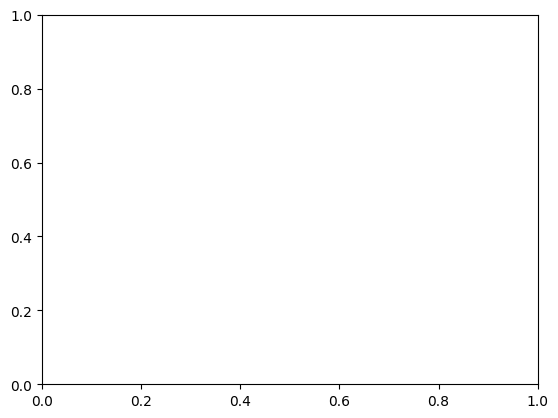

In [7]:
# Initialize figure

rc('animation', html = 'html5')

fig, ax = plt.subplots()

ax.set_xlim((0, 1))
ax.set_ylim((0, 1))

line, = ax.plot([], [], lw = 2)
line_BL, = ax.plot([], [], lw = 2)
line_ads, = ax.plot([], [], lw = 2)

In [8]:
# Initialization function
def init():
    line.set_data([], [])
    line_BL.set_data([], [])
    line_ads.set_data([], [])

    return (line, line_BL, line_ads)

In [9]:
# Prepare results for plotting

# Bulk
d = np.empty((seg + 2, len(m.time)))
d[0] = np.array(theta0.value)
for i in range(seg):
    d[i + 1] = np.array(theta[i].value)
d[-1] = np.array(theta1.value)
d = d.T

# Boundary later
d_BL = np.empty((seg + 1, len(m.time)))
for i in range(seg):
    d_BL[i] = np.array(theta_BL[i].value)
d_BL[-1] = np.array(theta1.value)
d_BL = d_BL.T

# Adsorbed
d_ads = beta * d_BL ** (1 / n)

In [10]:
# Animation function
def animate(i):
    x = dist
    y = d[i]
    y_BL = d_BL[i]
    y_ads = d_ads[i]

    # Bulk
    line.set_data(x, y)
    line.set_label('Bulk')

    # Boundary Layer
    line_BL.set_data(x[1:], y_BL)
    line_BL.set_label('Boundary Layer')

    # Adsorbed
    line_ads.set_data(x[1:], y_ads)
    line_ads.set_label('Adsorbed')

    # Set figure attributes
    ax.legend()
    ax.set_title('Spatiotemporal Diffusion')
    ax.set_xlabel('$\lambda = \\frac{x}{L}$')
    ax.set_ylabel('$\\theta = \\frac{C}{C_0}$')

    # Remove any existing text on figure
    for T in ax.texts:
        T.remove()

    # Update text
    ax.text(1.1, 0.9, "$\\frac{Dt}{L^{2}}$ = " + str(m.time[i].round(2)))
    ax.text(1.1, 0.8, "$\\frac{kL^{2}}{D}$ = " + str(alpha))
    ax.text(1.1, 0.7, "$\phi~\sqrt[n]{\\frac{S_0}{C_0}}$ = " + str(beta))
    ax.text(1.1, 0.6, "$n$ = " + str(n))

    fig.subplots_adjust(right = 0.7)

    return(line, line_BL, line_ads)

In [11]:
# Create animation
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = len(m.time), interval = 100, blit = True)
anim

In [12]:
# Save animation
anim.save('Diffusion.mp4', fps = 10)

In [13]:
m.time

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ])